In [1]:
import pickle, copy, json, os, h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps
from random import shuffle
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import la_forge.utils as lf_utils
lf_utils.set_publication_params({'text.usetex':False})
fig_dir = '/home/baierj/projects/hasasia2/hasasia2_paper/figures/'
os.chdir('/home/baierj/projects/hasasia2/pta_sensitivity_tuning/')

/home/baierj/anaconda3/envs/hasasia2/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as hutils
import hasasia.skymap as hsky
from hasasia.sensitivity import psd_from_background_realization as psd

In [3]:
import jax
jax.config.update("jax_enable_x64", True)

In [4]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [5]:
snr_3sig = 3.7145
# from scipy import integrate
# fap3sigma = integrate.quad(lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2*x**2), 3, np.inf)[0]
F0_3sig = 8.898 # hutils._solve_F0_given_SNR(snr_3sig)
print("false alarm rate for 3sigma: 0.0013517623131287832")#hutils.fap(F0_3sig))
print("F0 for 3sigma: ", F0_3sig)
print("S/N for 3sigma: ", snr_3sig)
# a fap of 0.0013 corresponds to a 3-sigma detection under a gaussian null distribution
# but here it corresponds to a S/N of 3.7145
# and a F0 of 8.898 for the hasasia detection statistic

false alarm rate for 3sigma: 0.0013517623131287832
F0 for 3sigma:  8.898
S/N for 3sigma:  3.7145


In [6]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 3
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)
np.random.seed(0)

In [7]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]
def start_filter(psrs, start_year=10):
    return [p for p in psrs if min(p.toas) < start_year*365.25*24*3600 ]
fyr = 1/(365.25*24*3600)
days = 24*3600
yr_sec = 365.25*24*3600
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)

In [8]:
def get_sliced_spectra(psrs, 
                       start_mjd=1,
                       end_mjd = None,
                       ):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
    
    sigma_correction : ?
        ???
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    for idx, psr in enumerate(psrs_copy):
        # filter the data around to the appropriate slice
        #print("N_toa = ", len(psr.toas))
        psr.filter_data(start_time=start_mjd, end_time=end_mjd)
        #print("after filter = ", len(psr.toas)) 
        # If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size == 0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)
    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for idx, p in enumerate(psrs_cut):
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        #print(f"psr spectra {idx} is done")
        spectra.append(sp)
    print(f"PTA spectrum with {len(spectra)} psrs created.")
    return spectra

In [9]:
# data used with permission from Emiko Gardiner
ssfile = h5py.File('/home/baierj/projects/hasasia2/extra_data/sam_lib.hdf5', 'r') 
hc_bg = ssfile['hc_bg'][202,...]
hc_ss = ssfile['hc_ss'][202,...]
fobs = ssfile['fobs'][:]
ssfile.close()
dfobs=np.ones(len(fobs))*(fobs[1]-fobs[0])
silver = '#cebebe'
dots = '#E55812'
#thankfully fobs is evenly spaced. so dfobs is just the difference between first and second freq bin

## Sam lib data
### used with permission from Emiko Gardiner
Description: 500 samples (drawn from a uniform param space similar to the one in the awg paper), each of which have 100 realizations. sorted them by how well they match the 1/10yr 15yr GWB characteristic strain detection, cuz at that frequency the strain amplitude and spectral index are pretty covariant. Ranking from best to worst sample is in the npz array, but the 10 best are, in order
202 103 452 111 117  79 180 276 245 479

the hc_bg and hc_ss in the hdf file are shaped (nsamples, nfreqs, nreals) and (nsamples, nfreqs, nreals, nloudest)
## hc_bg:(nsamples, nfreqs, nreals)
## hc_ss: (nsamples, nfreqs, nreals, nloudest) 

In [10]:
print("The 202nd sample:")
print("fobs: ",len(fobs))
print("hc_bg: ", hc_bg.shape)
print("hc_ss: ", hc_ss.shape)


The 202nd sample:
fobs:  40
hc_bg:  (40, 100)
hc_ss:  (40, 100, 5)


In [11]:
np.random.seed(0)
random_samples = np.array([int(np.rint(i)) for i in np.random.uniform(0,499,10)])
random_samples

array([274, 357, 301, 272, 211, 322, 218, 445, 481, 191])

In [12]:
# data used with permission from Emiko Gardiner
mult_hc_bg = []
mult_new_bgs = []
mult_hc_ss = []
mult_c_i = []
realization_per_sample = 100
for s in random_samples:
    ssfile = h5py.File('/home/baierj/projects/hasasia2/extra_data/sam_lib.hdf5', 'r') 
    hc_bg = ssfile['hc_bg'][s,...][:, ::1]
    hc_ss = ssfile['hc_ss'][s,...][:,::1,:]
    ssfile.close()
    # can either think about the background as being the binaries including the foreground
    new_hc_bg = np.sqrt(hc_bg**2 + np.sum(hc_ss[:,:,:]**2, axis=-1))
    # or not including the foreground
    #new_hc_bg = hc_bg
    c_i = np.sqrt((10**A_gwb)**2*(fobs/fyr)**(2*alpha_gwb)/np.quantile(new_hc_bg,0.5,axis=-1)**2)
    cis = np.array([c_i for _ in range(realization_per_sample)]).T
    mult_hc_bg.append(hc_bg)
    mult_new_bgs.append(new_hc_bg)
    mult_c_i.append(cis)
    mult_hc_ss.append(hc_ss)
hc_bg = np.concatenate(mult_hc_bg, axis=1)
hc_ss = np.concatenate(mult_hc_ss,axis=1)/5.
c_i = np.concatenate(mult_c_i, axis=1)
new_hc_bg =np.concatenate(mult_new_bgs, axis=1)
hc_bg.shape, hc_ss.shape, c_i.shape, new_hc_bg.shape

((40, 1000), (40, 1000, 5), (40, 1000), (40, 1000))

# 1) Load individual pulsar parameters from `creating_pta.ipynb` and build functionality to simulate ptas with different injected GWBs

In [13]:
def reset_psrs():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'./data/gpta_psrs_40yrs_v2/gpta_psr_{i}_v2.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` in from `creating_pta.ipynb`.")
    return gpta_psrs_40yrs
gpta_psrs_40yrs = reset_psrs()

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [14]:
# for some reason these sigmas are bad. not sure why.
unweighted_sigmas = np.array([4.34518856e-07, 3.97324530e-07, 6.25306787e-07, 1.34130112e-07,
       3.90101962e-07, 5.52324281e-07, 5.21365086e-07, 5.77405433e-07,
       4.52103376e-07, 7.21854779e-07, 1.61859269e-06, 2.94116573e-07,
       6.24232150e-07, 3.07853559e-07, 1.17952896e-06, 5.34561571e-07,
       6.90281801e-07, 3.61565718e-07, 3.20459534e-07, 5.93774686e-07,
       5.10433107e-07, 2.50755671e-06, 1.32521045e-06, 1.28874134e-06,
       1.92803093e-06, 2.21432255e-07, 6.71426801e-07, 7.18374875e-07,
       3.69499555e-06, 4.63231645e-07, 4.25080125e-07, 2.53568478e-07,
       1.26573261e-07, 2.34159916e-06, 9.76946563e-07, 1.36995656e-06,
       4.55219608e-07, 7.21289531e-07, 1.95039382e-07, 5.92130210e-07,
       5.49288698e-06, 1.69376752e-06, 5.00340069e-07, 3.66115606e-06,
       4.18631626e-07, 2.69122732e-06, 2.52249570e-06, 1.40257482e-06,
       8.26683042e-07, 1.68034269e-06, 4.63909251e-07, 1.53424624e-06,
       7.94683605e-07, 1.24060439e-07, 5.05572358e-07, 3.23790693e-07,
       5.80022741e-06, 5.87243347e-07, 6.00138151e-07, 8.50446173e-07,
       5.18050366e-07, 3.12560674e-07, 1.45745017e-06, 3.69100686e-07,
       6.16362527e-07, 4.11295707e-07, 2.45885492e-07, 1.60895486e-06,
       5.18608215e-06, 3.59412871e-06, 1.97436370e-06, 1.34471109e-06,
       4.96156204e-07, 2.18227739e-07, 5.41430815e-07, 4.19005157e-07,
       3.08259405e-07, 1.78580302e-07, 1.21709038e-06, 1.22658590e-07,
       1.33692644e-06, 3.22578694e-07, 2.16073847e-07, 2.30196761e-07,
       9.87464341e-07, 4.28323489e-07, 5.49715529e-07, 6.78742460e-07,
       1.59951073e-06, 1.22344006e-06, 4.46608936e-07, 3.07288234e-07,
       1.81516015e-07, 4.70622425e-07, 4.40510156e-07, 5.72523992e-07,
       1.04480211e-06, 1.09297969e-06, 4.56585407e-07, 5.24803843e-07,
       3.59156611e-07, 1.37776280e-06, 1.83770050e-07, 1.09837396e-06,
       1.35522007e-06, 1.35230016e-06, 4.38525905e-07, 5.21152680e-07,
       7.23087913e-07, 4.48478319e-07, 5.19393909e-07, 3.77548691e-07,
       5.74958145e-07, 1.65872889e-07, 1.40396920e-06, 6.19380009e-07,
       3.24885943e-07, 1.25622102e-07, 3.05302639e-07, 1.73242995e-06,
       3.94053989e-07, 1.20227823e-07, 1.93193292e-07, 1.27619788e-07,
       3.18992484e-07, 5.95613167e-07, 3.46313950e-06, 6.98844466e-07,
       7.27561592e-07, 5.63238211e-07, 6.31706322e-07, 6.51748219e-07,
       5.87923131e-07, 6.28118913e-07, 1.33005469e-06, 1.47433890e-06,
       2.14313979e-07, 2.34318016e-07, 1.00151280e-06, 5.47562108e-07,
       4.64952780e-07, 5.01761091e-07, 7.54266806e-07, 1.12049623e-06,
       1.29914769e-06, 2.88652276e-07, 4.48644040e-07, 4.42071570e-07,
       4.99513102e-07, 1.38001639e-06, 4.60977408e-07, 1.72544662e-07,
       5.59933540e-07, 1.39531076e-06, 5.09449330e-07, 7.30921220e-07,
       4.81412433e-07])
timespans = np.array([35.12220489, 27.52376839, 30.61358484, 32.19335777, 39.69199198,
       27.84951415, 30.97121053, 27.58934466, 30.19352916, 33.14840048,
       29.10992631, 28.33522001, 27.95412538, 32.72845017, 34.9117191 ,
       34.58603486, 39.79876208, 27.50308901, 34.24012713, 32.94500606,
       32.83648009, 39.85428066, 27.55964202, 34.92865686, 39.25918549,
       31.9037563 , 30.07274164, 36.66100955, 27.88044159, 31.25934142,
       32.04548596, 34.89336798, 27.85506703, 28.53649693, 31.0060101 ,
       33.15830638, 39.55168903, 33.11668926, 28.02500688, 39.92536802,
       39.49111827, 31.80475773, 39.69293604, 32.34484421, 39.69676021,
       39.32392204, 39.87629797, 39.68269723, 27.63612717, 28.1898967 ,
       30.83703605, 39.8118608 , 29.46672982, 28.13280126, 39.54907017,
       31.29413729, 39.63516992, 28.13185457, 34.43460361, 31.24519656,
       27.79759398, 34.92838743, 28.7559876 , 27.65042344, 27.73156517,
       27.73609246, 39.63460059, 35.53498217, 39.59600066, 34.59476859,
       32.17104345, 29.54901298, 39.99474825, 30.46703781, 31.48775986,
       30.69134417, 39.92116419, 28.1894432 , 29.98751993, 34.70326574,
       27.74459062, 33.00886955, 31.54362093, 29.16816083, 28.65556485,
       31.96949349, 30.54720582, 31.37496839, 30.12181196, 39.88510828,
       28.02491891, 27.87868944, 30.20443628, 32.85778263, 34.407487  ,
       30.90187408, 40.        , 30.32320026, 35.27685221, 33.29137693,
       39.25669167, 39.90798728, 39.56299638, 35.92678903, 34.9533288 ,
       30.09416207, 28.081782  , 27.74230904, 28.69455189, 31.18147454,
       32.07403954, 36.16488454, 39.83819743, 27.96058058, 27.9194032 ,
        1.        ,  1.        ,  2.00643501,  2.00643501,  3.01287003,
        3.01287003,  4.01930504,  4.01930504,  5.02574005,  5.02574005,
        6.03217507,  6.03217507,  7.03861008,  7.03861008,  8.0450451 ,
        8.0450451 ,  9.05148011,  9.05148011, 10.05791512, 10.05791512,
       11.06435014, 11.06435014, 12.07078515, 12.07078515, 13.07722016,
       13.07722016, 14.08365518, 14.08365518, 15.09009019, 15.09009019,
       16.0965252 , 16.0965252 , 17.10296022, 17.10296022, 18.10939523,
       18.10939523, 19.11583025, 19.11583025, 20.12226526, 20.12226526,
       21.12870027, 21.12870027])

In [15]:
# get the tspans, irn, etc.
tests_psr = gpta_psrs_40yrs[0]
tests_psr.phi
names = []
[names.append(gpta_psrs_40yrs[i].name) for i in range(len(gpta_psrs_40yrs))]
phis = []
[phis.append(gpta_psrs_40yrs[i].phi) for i in range(len(gpta_psrs_40yrs))]
thetas = []
[thetas.append(gpta_psrs_40yrs[i].theta) for i in range(len(gpta_psrs_40yrs))]
A_rn = []
[A_rn.append(gpta_psrs_40yrs[i].A_rn) for i in range(len(gpta_psrs_40yrs))]
alpha_rn = []
[alpha_rn.append(gpta_psrs_40yrs[i].alpha) for i in range(len(gpta_psrs_40yrs))]
tuned_sigmas = 1.13*unweighted_sigmas*np.sqrt(np.pi)
sigmas = []
[sigmas.append(gpta_psrs_40yrs[i].toaerrs[0]) for i in range(len(gpta_psrs_40yrs))]
len(names), len(phis), len(thetas), len(A_rn), len(alpha_rn), len(sigmas)

(157, 157, 157, 157, 157, 157)

In [16]:
def sim_pta_w_inj_gwb(A_gwb, alpha_gwb):
    print(f"Creaing array of {len(names)} psrs with injected A_gwb: {np.log10(A_gwb)} and alpha_gwb: {alpha_gwb:.2f} ...")
    return hsim.sim_pta(timespan=timespans, # need units to be years
                psr_names=names,
                cad=20,
                sigma=np.array(sigmas),#1.13*unweighted_sigmas*np.sqrt(np.pi),#*np.sqrt(np.pi), # the sqrt(pi) is DMX transmission function and the 1.13 is like efac or something
                A_rn=A_rn,
                alpha=alpha_rn,
                freqs=freqs,
                A_gwb=A_gwb,
                #gamma_gwb=-2/3,
                alpha_gwb=alpha_gwb,
                phi=phis,
                theta=thetas,
                uneven=True)

In [17]:
psrs_sim_gpta_full = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb) 

Creaing array of 157 psrs with injected A_gwb: -14.29 and alpha_gwb: -0.22 ...


2024-12-15 21:17:48.960116: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Confirm that the spectrum looks good. Should get an SNR of ~32 for both the loaded and created pulsars.

In [18]:
full_specs_gpta_loaded = []
full_specs_gpta_created = []
for p in tspan_filter(gpta_psrs_40yrs):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    full_specs_gpta_loaded.append(sp)
for p in tspan_filter(psrs_sim_gpta_full):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    full_specs_gpta_created.append(sp)
GWBSC_loaded = hsen.GWBSensitivityCurve(spectra=full_specs_gpta_loaded, orf='hd', autocorr=False)
GPTA_GWB_SNR_loaded = GWBSC_loaded.SNR(S_h)
gwb_label_loaded = f"loaded spectrum with GWB SNR={GPTA_GWB_SNR_loaded:.3f}"
GWBSC_created = hsen.GWBSensitivityCurve(spectra=full_specs_gpta_created, orf='hd', autocorr=False)
GPTA_GWB_SNR_created = GWBSC_created.SNR(S_h)
gwb_label_created = f"created spectrum with GWB SNR={GPTA_GWB_SNR_created:.3f}"
print(f"GPTA GWB SNR loaded : {GPTA_GWB_SNR_loaded:.2f}")
print(f"GPTA GWB SNR created : {GPTA_GWB_SNR_created:.2f}")

GPTA GWB SNR loaded : 32.04
GPTA GWB SNR created : 32.04


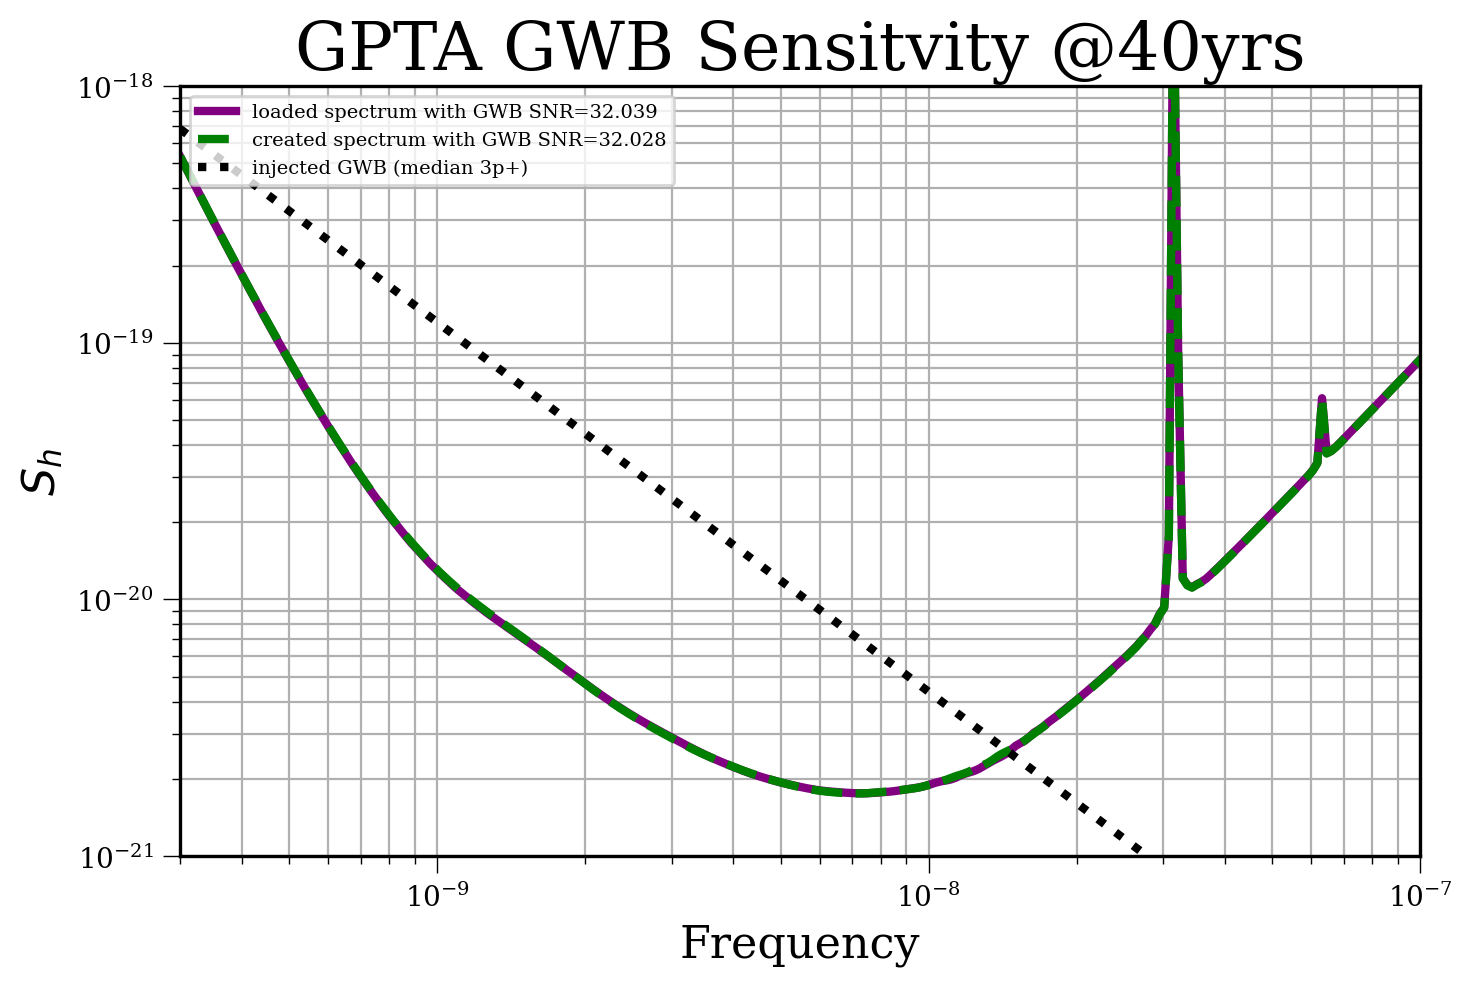

In [19]:
# Plot GWB SC
plt.figure(figsize=[8,5])
plt.loglog(GWBSC_loaded.freqs, GWBSC_loaded.S_eff,label=gwb_label_loaded, color = "Purple", linewidth= 3, )
plt.loglog(GWBSC_created.freqs, GWBSC_created.S_eff,label=gwb_label_created, color = "Green", linewidth= 3,  linestyle = '--')
plt.loglog(GWBSC_created.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB (median 3p+)")
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylim((1e-21,1e-18))
plt.xlim((3e-10, 1e-7))
plt.ylabel('$S_h$', fontsize=16)
plt.title('GPTA GWB Sensitvity @40yrs', fontsize = 24)
plt.grid(which='both')
plt.show()

In [18]:
# sources
#mass in Msun, D_L in Mpc, f(_GW?) in Hz
s1 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=7e-10).to('')
s2 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=4e-9).to('')
s3 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=1.15e-8).to('')
s4 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=2.8e-8).to('')
source_h0s = [s1.value, s2.value, s3.value, s4.value]
#h0_freqs = [7e-10, 4e-9, 1.15e-8, 2.8e-8] 
# swapping to the below since they fit our curve better?
h0_freqs = [2e-9, 5e-9, 2e-8, 4e-8]
source_freqs = [np.argmin(abs(freqs-h0_freqs[i])) for i in range(len(h0_freqs))]
source_h0s

[2.7443824468119924e-15,
 8.77174370311675e-15,
 1.7735543416856256e-14,
 3.2098491819673166e-14]

# 2) How sensitive is our background subtraction to our background parameter estimation??
### We can bound our background subtraction error by considering the limiting cases:
-  ### perfect subtraction --> inject $A_{GWB}/2$
    - half of the GWB self noise because we perfectly fit out earth term of GWB
- ### no subtraction --> inject $A_{GWB}$
    - full GWB self noise because we don't fit out earth term of GWB at all

## 2A) let's try this first for the dropping pulsars case

In [19]:
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
hpsrs_perf_sub = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb/2, alpha_gwb = alpha_gwb)
hpsrs_no_sub = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb)

Creaing array of 157 psrs with injected A_gwb: -14.59102999566398 and alpha_gwb: -0.22 ...
Creaing array of 157 psrs with injected A_gwb: -14.29 and alpha_gwb: -0.22 ...


In [ ]:
# this bit of code goes through and finds the best psrs
hpsrs = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb)
end_year = 20.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

In [ ]:
# create modified campaign
start_year = 20
end_year = 30.01
cadence_factor = 4
pulsars_dropped_per_year = 6
thing_cadence_factor=1/2
iterations = 12

In [ ]:
# need to think here about whether or not we want to "recalculate" all of the psrs to be removed when we injected A/2 instead
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)
# gwb snr dropout ranking
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

In [ ]:
# high cadence based off best rms
# remove based off of contribution to gwb
psrs_high_cad = idx_best_to_worst_filtered[:iterations]
psrs_removed = idx_sorted_filtered[:iterations*pulsars_dropped_per_year+3]
psrs_high_cad, np.array(psrs_removed), np.intersect1d(psrs_high_cad, psrs_removed)
#confirm that we arent removing and doing high cadence on same pulsar w/ intersection

#### Alt. campaign w perfec subtraction (A/2)

In [ ]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb/2, alpha_gwb = alpha_gwb)
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # "remove" pulsars with .filter_data() function
        for idx in range(pulsars_dropped_per_year):
                print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[idx_sorted_filtered[i*pulsars_dropped_per_year+idx]].name)
                hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].change_cadence(
                        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                        cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                        A_gwb=10**A_gwb/2, alpha_gwb=alpha_gwb, freqs=freqs)
    print(f"{i+1})removing pulsars ", hpsrs[psrs_removed[i]].name, hpsrs[psrs_removed[i+1]].name, hpsrs[psrs_removed[i+2]].name)
    [hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].filter_data(start_time=0, end_time=start_year*365.25) for idx in range(pulsars_dropped_per_year)]
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
    start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
    cadence=None, cadence_factor=cadence_factor, uneven=False,
    A_gwb=10**A_gwb/2, alpha_gwb=alpha_gwb, freqs=freqs,
    )
    print("toas after: ", len(hpsrs[psr_hcad].toas))
    # create psr spectra at end of cadence  
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])

### alt. campaign with no subtraction

In [ ]:
GWBSCs_nosub = []
GWBSNRs_nosub = []
SNRs_nosub = []
SMs_nosub = []
hpsrs = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb)
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs_nosub.append(hsen.GWBSensitivityCurve(spectra))
SMs_nosub.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs_nosub.append(GWBSCs_nosub[-1].SNR(S_h))
SNRs_nosub.append([0.5*SMs_nosub[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # "remove" pulsars with .filter_data() function
    print(f"{i+1})removing pulsars ", hpsrs[psrs_removed[i]].name, hpsrs[psrs_removed[i+1]].name, hpsrs[psrs_removed[i+2]].name)
    [hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].filter_data(start_time=0, end_time=start_year*365.25) for idx in range(pulsars_dropped_per_year)]
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=False,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
    )
    print("toas after: ", len(hpsrs[psr_hcad].toas))
    # create psr spectra at end of cadence  
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs_nosub.append(hsen.GWBSensitivityCurve(spectra))
    SMs_nosub.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs_nosub.append(GWBSCs_nosub[-1].SNR(S_h))
    SNRs_nosub.append([0.5*SMs_nosub[-1].SNR(h_0) for h_0 in source_h0s])

In [ ]:
# Plot skymap SC
dropped = 3* np.array([i for i in range(0,len(SNRs))])
color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
plt.figure(figsize=[8,5])
for i, sc in enumerate(SMs):
    linewidth=1
    plt.loglog(freqs, 2*np.mean(SMs[i].h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
    plt.loglog(freqs, 2*np.mean(SMs_nosub[i].h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
#plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
for i in range(len(h0_freqs)):
    plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
#plt.legend(loc='upper left', fontsize=10,)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('$h_{c}$', fontsize=16)
plt.title(f'GWB subtraction comp. "gwb noise removal" @{end_year:.1f}yrs', fontsize = 18)
plt.grid(which='both')
plt.xlim((4e-10, 1e-7))
plt.ylim((2e-15, 8e-13))
plt.savefig(f'{fig_dir}/x4cad_gwb_snr_psr_drop_background_sub.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([0.5*np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
SNRs2 = []
for i in range(len(GWBSNRs_nosub)):
    SNRs2.append([0.5*np.mean(SMs_nosub[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])

In [ ]:
plt.figure(figsize=[6,4])
src_snr = np.array(SNRs).T
src_snr2 = np.array(SNRs2).T
dropped = 3*np.array([i for i in range(1,len(GWBSNRs)+1)])
for i in range(len(SNRs[0])):
    plt.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='x', color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz", linestyle='')
    plt.plot(dropped, 100*src_snr2[i]/src_snr2[i][0], marker='+', color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz", linestyle='')
#plt.title("Source S/N swapping 3psr for a x4 high cadence, yr 20->30")
plt.xlabel("Pulsars no longer observed", fontsize=14)
plt.ylabel("% std. campaign S/N", fontsize=16)
cross = mlines.Line2D([], [], color='grey', marker='x', linestyle='None',
                          markersize=8, label='perfect sub.: A/2')
plus = mlines.Line2D([], [], color='grey', marker='+', linestyle='None',
                          markersize=10, label='no sub. A')
plt.legend(handles=[plus, cross], loc=(0.01,0.75))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{fig_dir}/x4cad_src_snr_psr_drop_background_sub.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

## 2B) let's try this now with doing the halved cadences

In [58]:
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
hpsrs_perf_sub = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb/2, alpha_gwb = alpha_gwb)
hpsrs_no_sub = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb)

Creaing array of 157 psrs with injected A_gwb: -14.59102999566398 and alpha_gwb: -0.22 ...
Creaing array of 157 psrs with injected A_gwb: -14.29 and alpha_gwb: -0.22 ...


In [59]:
# this bit of code goes through and finds the best psrs
hpsrs = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb)
end_year = 20.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

Creaing array of 157 psrs with injected A_gwb: -14.29 and alpha_gwb: -0.22 ...
PTA spectrum with 115 psrs created.


In [60]:
# create modified campaign
start_year = 20
end_year = 30.01
cadence_factor = 4
reduced_cadence_factor = 1/2.
pulsars_dropped_per_year = 6 #not actually dropping. just halving cadence
iterations = 10

In [61]:
# need to think here about whether or not we want to "recalculate" all of the psrs to be removed when we injected A/2 instead
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)
# gwb snr dropout ranking
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [62]:
# high cadence based off best rms
# remove based off of contribution to gwb
psrs_high_cad = idx_best_to_worst_filtered[:iterations]
psrs_removed = idx_sorted_filtered[:iterations*pulsars_dropped_per_year+3]
psrs_high_cad, np.array(psrs_removed), np.intersect1d(psrs_high_cad, psrs_removed)
#confirm that we arent removing and doing high cadence on same pulsar w/ intersection

([79, 53, 32, 3, 113, 77, 92, 102, 38, 82],
 array([  7,  17,   1,  28,   9,  11,  33,  69,  43,  49,  18,  80,  56,
         68,  22,   5,  40,  62, 114,  88,  19,  64,  12,  71,  84,  10,
         90,  97,  34, 105,  78,  48,  70, 107,  14,   6,  46,  41,  15,
         60,  35,  51,  89,  65,  52, 101,  95, 108,  57,  45,  26, 109,
         74,  24,   8,  67,   2,  58,  21, 104,  85,  59,  63]),
 array([], dtype=int64))

#### Alt. campaign w perfec subtraction (A_gwb/2)

In [63]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb/2, alpha_gwb = alpha_gwb)
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # halve pulsars cadence with .change_cadence()
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=reduced_cadence_factor, uneven=False,
                A_gwb=10**A_gwb/2, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=False,
        A_gwb=10**A_gwb/2, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    print("toas after: ", len(hpsrs[psr_hcad].toas))
    # create psr spectra at end of cadence  
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])

Creaing array of 157 psrs with injected A_gwb: -14.59102999566398 and alpha_gwb: -0.22 ...
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J2052+0211
old: 550, new: 450
1:4) reducing pulsar  J2100-0048
old: 557, new: 456
1:5) reducing pulsar  J1535-0011
old: 662, new: 562
1:6) reducing pulsar  J0122-0052
old: 566, new: 466
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
toas after:  1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1848+0110
old: 570, new: 470
2:2) reducing pulsar  J2154-0231
old: 691, new: 591
2:3) reducing pulsar  J1514-0303
old: 646, new: 546
2:4) reducing pulsar  J2249-0019
old: 563, new: 463
2:5) reducing pulsar  J1135+0251
old: 684, new: 583
2:6) reducing pulsar  J1641-0037
old: 554, new: 454
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
toas after:  1159
PTA spectrum with 133 psrs created.
3

### alt. campaign with no subtraction (A_gwb)

In [64]:
GWBSCs_nosub = []
GWBSNRs_nosub = []
SNRs_nosub = []
SMs_nosub = []
hpsrs = sim_pta_w_inj_gwb(A_gwb = 10**A_gwb, alpha_gwb = alpha_gwb)
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs_nosub.append(hsen.GWBSensitivityCurve(spectra))
SMs_nosub.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs_nosub.append(GWBSCs_nosub[-1].SNR(S_h))
SNRs_nosub.append([SMs_nosub[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # halve pulsars cadence with .change_cadence()
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=reduced_cadence_factor, uneven=False,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=False,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
    )
    print("toas after: ", len(hpsrs[psr_hcad].toas))
    # create psr spectra at end of cadence  
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs_nosub.append(hsen.GWBSensitivityCurve(spectra))
    SMs_nosub.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs_nosub.append(GWBSCs_nosub[-1].SNR(S_h))
    SNRs_nosub.append([SMs_nosub[-1].SNR(h_0) for h_0 in source_h0s])

Creaing array of 157 psrs with injected A_gwb: -14.29 and alpha_gwb: -0.22 ...


PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J2052+0211
old: 550, new: 450
1:4) reducing pulsar  J2100-0048
old: 557, new: 457
1:5) reducing pulsar  J1535-0011
old: 662, new: 562
1:6) reducing pulsar  J0122-0052
old: 566, new: 466
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
toas after:  1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1848+0110
old: 570, new: 469
2:2) reducing pulsar  J2154-0231
old: 691, new: 591
2:3) reducing pulsar  J1514-0303
old: 646, new: 546
2:4) reducing pulsar  J2249-0019
old: 563, new: 463
2:5) reducing pulsar  J1135+0251
old: 684, new: 584
2:6) reducing pulsar  J1641-0037
old: 554, new: 454
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
toas after:  1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J0326+0145
old: 792, new: 691
3:2) reducing pulsar  J1015+0331
old: 79

In [65]:
len(SNRs)

11

In [20]:
#@np.vectorize
def strain_and_chirp_mass_to_luminosity_distance(h, M_c, f0):
    return (4*hsky.c.c / (h * hsky.u.m/hsky.u.m)
            * np.power(hsky.c.G * M_c * hsky.u.Msun/hsky.c.c**3, 5/3)
            * np.power(np.pi * f0 * hsky.u.Hz, 2/3)).to('Mpc')

def calculate_detection_volume(skymap, frequency, SNR_threshold, M_c):
    """
    Calculates the detection volume of your PTA
    at a given frequency or list of frequencies.

    Parameters
    ==========
    skymap - hasasia.skymap
        the hasasia.skymap to use
    frequency - float
        the frequency [Hz] at which to calculate detection volume
    SNR_threshold - float
        the signal to noise to referene detection volume to
    M_c - float
        the chirp mass [Msun] at which to reference detection volume
    Returns
    =======
    volume - float
        the detection volume in Mpc^3
    """
    NSIDE = hp.pixelfunc.npix2nside(skymap.S_eff.shape[1])
    dA = hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)
    if isinstance(frequency, (int,float)):
        f_idx = np.array([np.argmin(abs(skymap.freqs - frequency))])
    elif isinstance(frequency, (np.ndarray, list)):
        f_idx = np.array([np.argmin(abs(skymap.freqs - f)) for f in frequency])
    h0 = skymap.h_thresh(SNR=SNR_threshold)
    volume = [dA*np.sum(
        strain_and_chirp_mass_to_luminosity_distance(h0[fdx], M_c, skymap.freqs[fdx])**3,
        axis=0).value for fdx in f_idx]
    return volume[0] if len(volume)==1 else volume

In [67]:
SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
SNRs2 = []
for i in range(len(GWBSNRs_nosub)):
    SNRs2.append([np.mean(SMs_nosub[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
src_snr = np.array(SNRs).T
src_snr2 = np.array(SNRs2).T
snr_3sig = 3.7145
detvol1 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs)]).T
detvol2 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs_nosub)]).T

In [68]:
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
nhz = [int(h0_freqs[i]/1e-9) for i in range(4)] 
#inset_legs = [mpatches.Patch(color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(nhz[i]))) for i in range(len(SNRs[0]))]
#inset_legs = [mpatches.Patch(color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i]))) for i in range(len(SNRs[0]))]
legs = [mpl.lines.Line2D([0], [0], color='C3', markeredgecolor=None, linestyle='', marker='s', markersize=10, 
                         label=r"$\rm f_{\rm GW}$: "+"${}$ nHz".format(nhz[3])),
        mpl.lines.Line2D([0], [0], color='C2', markeredgecolor=None, linestyle='', marker='s', markersize=10,  
                         label=r"$\rm f_{\rm GW}$: "+"${}$ nHz".format(nhz[2])),
        mpl.lines.Line2D([0], [0], color='C1', markeredgecolor=None, linestyle='', marker='s', markersize=10,
                         label=r"$\rm f_{\rm GW}$:   "+"${}$ nHz".format(nhz[1])),
        mpl.lines.Line2D([0], [0], color='C0', markeredgecolor=None, linestyle='', marker='s', markersize=10,
                         label=r"$\rm f_{\rm GW}$:   "+"${}$ nHz".format(nhz[0])),
        mpl.lines.Line2D([0], [0], color='gray', markeredgecolor=None, linestyle='', marker='o', markersize=10,
                         label="GWB fit"),
        mpl.lines.Line2D([0], [0], color='gray', markeredgecolor=None, linestyle='', marker='^', markersize=10,
                         label="no GWB fit",),
        ]

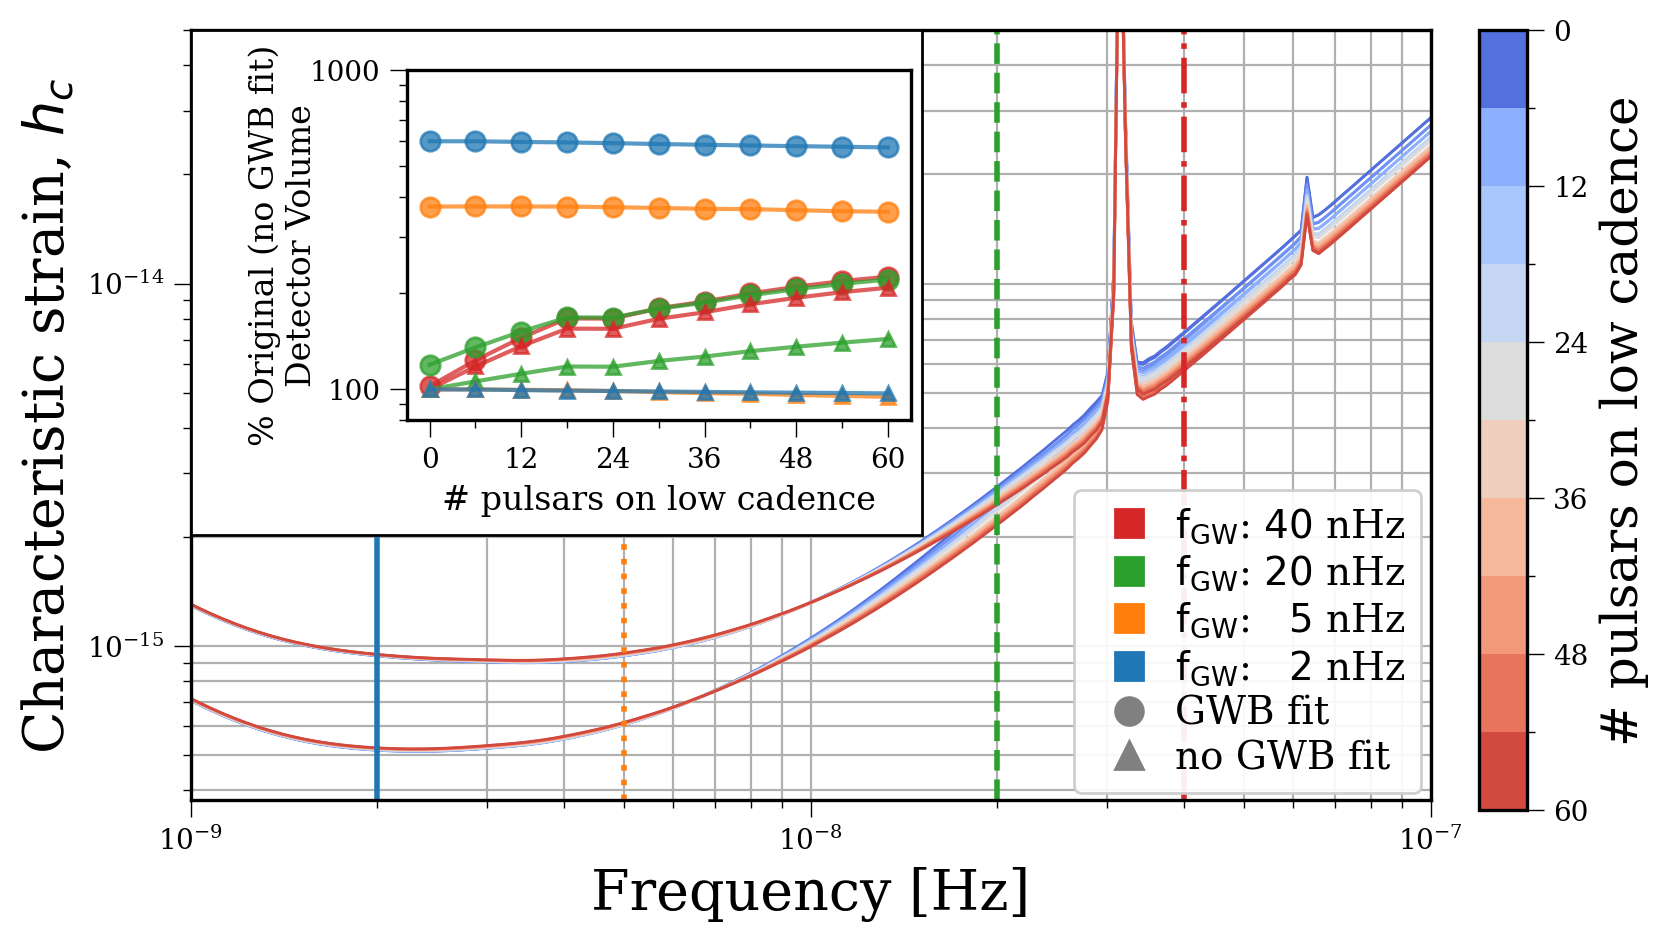

In [ ]:
# Plot skymap SC
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(GWBSNRs))])
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1,zorder=0)
for i, sc in enumerate(SMs):
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=1, alpha=1.0)
for i, sc in enumerate(SMs_nosub):
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=1, alpha=1.0)
for i in range(len(h0_freqs)):
    plt.axvline(h0_freqs[i], linestyle=linestyles[i], color=f'C{i}', linewidth=2)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel(r'Characteristic strain, $h_{c}$', fontsize=20)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((1.5e-15/4, 2e-13/4))
ax1.legend(handles=legs, loc=(0.7125,0.01), fontsize=14,framealpha=0.925, labelspacing=0.2, handletextpad=0.2)
#plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
loc_box = [0.00, 0.345, 0.59, 0.655]
buffer=0.0
#### make the inset plot
left, bottom, width, height = [0.23+.03, 0.49, 0.345-.03, 0.35]
ax3 = fig.add_axes([left, bottom, width, height])
ax1.add_patch(plt.Rectangle((
    loc_box[0]-buffer, loc_box[1]-buffer,), 
    loc_box[2]+buffer, loc_box[3]+buffer, 
    linestyle="-", edgecolor="k", facecolor="w", 
    linewidth=1, alpha=1,zorder=21, #zorder=5, 
    transform=ax1.transAxes))
markerss= ['1', '2', 'o', 'o']
sizess = [6,6,6,6]
for i in np.flip(range(4)):
    ax3.plot(dropped, 100*np.array(detvol1[i]/detvol2[i][0]), marker='o', markersize=7, color=f'C{i}',#color=source_colors[i],
             label=r"$\rm f_{\rm GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])),
             linestyle='-', alpha=0.75)
for i in np.flip(range(4)):
    ax3.plot(dropped, 100*np.array(detvol2[i]/detvol2[i][0]), marker='^', markersize=5, color=f'C{i}',#color=source_colors[i],
             label=r"$\rm f_{\rm GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])),
             linestyle='-', alpha=0.75)
ax3.set_xlabel('# pulsars on low cadence', fontsize=12)
ax3.set_ylabel("% Original (no GWB fit)\nDetector Volume", fontsize=12, labelpad=-3)
ax3.set_xticks(np.arange(0,61,6), minor=True)
ax3.set_xticks(np.arange(0,61,12))
ax3.set_ylim(80,1000)
ax3.set_yscale('symlog')
ax3.set_yticks([100,1000],[100,1000])
ax3.set_yticks(np.concatenate([[80,90],np.linspace(100,1000,10)]),minor=True)
#ax3.legend(fontsize=6.25)
#### make the color bar
# ax2 = fig.add_axes([0.99, 0.1, 0.03, 0.78]) if you want the double color bar use this.
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                 spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
ax2.set_ylabel('# pulsars on low cadence', fontsize=18)
for label in ax2.get_yticklabels(minor=True):
    label.set_verticalalignment('center')
#plt.savefig(f'{fig_dir}/x4cad_half_cad_psr_background_sub_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

# 3) Compare different injected GWBs at 30 yrs

In [20]:
#gamma_gwbs = [2.5, 2.8, 3.15, 3.44, 3.8, 4.15, 4.5]
#A_gwbs = [-13.9, -14.1, -14.2, -14.29, -14.4, -14.65, -14.72]
gamma_gwbs = [2.66, 3.05, 3.44, 3.97,4.5]
A_gwbs = [-13.95, -14.12, -14.29, -14.52, -14.75]
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
alpha_gwbs = (3. - np.array(gamma_gwbs)) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)
S_hs = []
inj_gwb_hcs = []
[S_hs.append(hsen.S_h(A=10**A_gwbs[i], alpha=alpha_gwbs[i], freqs=freqs)) for i in range(len(alpha_gwbs))]
[inj_gwb_hcs.append(np.sqrt(hsen.S_h(A=10**A_gwbs[idx], alpha=alpha_gwbs[idx], freqs=freqs)*freqs)) for idx, _ in enumerate(S_hs)]

[None, None, None, None, None]

### take pop sims and readjust them to each of the backgrounds
### gotta be careful about this because we need to adjust for each draw from the parameter space

In [21]:
c_i.shape

(40, 1000)

In [22]:
varying_cis = {idx: [] for idx in range(len(alpha_gwbs))}
for idx in range(len(A_gwbs)):
    total_ci = []
    for i in range(10): # loop over parameter draws
        # get 100 cis to append
        param_ci = np.sqrt((10**A_gwbs[idx])**2*(fobs/fyr)**(2*alpha_gwbs[idx])/np.median(new_hc_bg[:, i*100:(i+1)*100],axis=-1)**2)
        #print(param_ci.shape)
        total_ci.append([param_ci for _ in range(100)])
    varying_cis[idx] = np.concatenate(total_ci, axis=0).T
    #varying_cis[idx].append([param_ci for ])

In [23]:
list(varying_cis.keys()), varying_cis[0].shape

([0, 1, 2, 3, 4], (40, 1000))

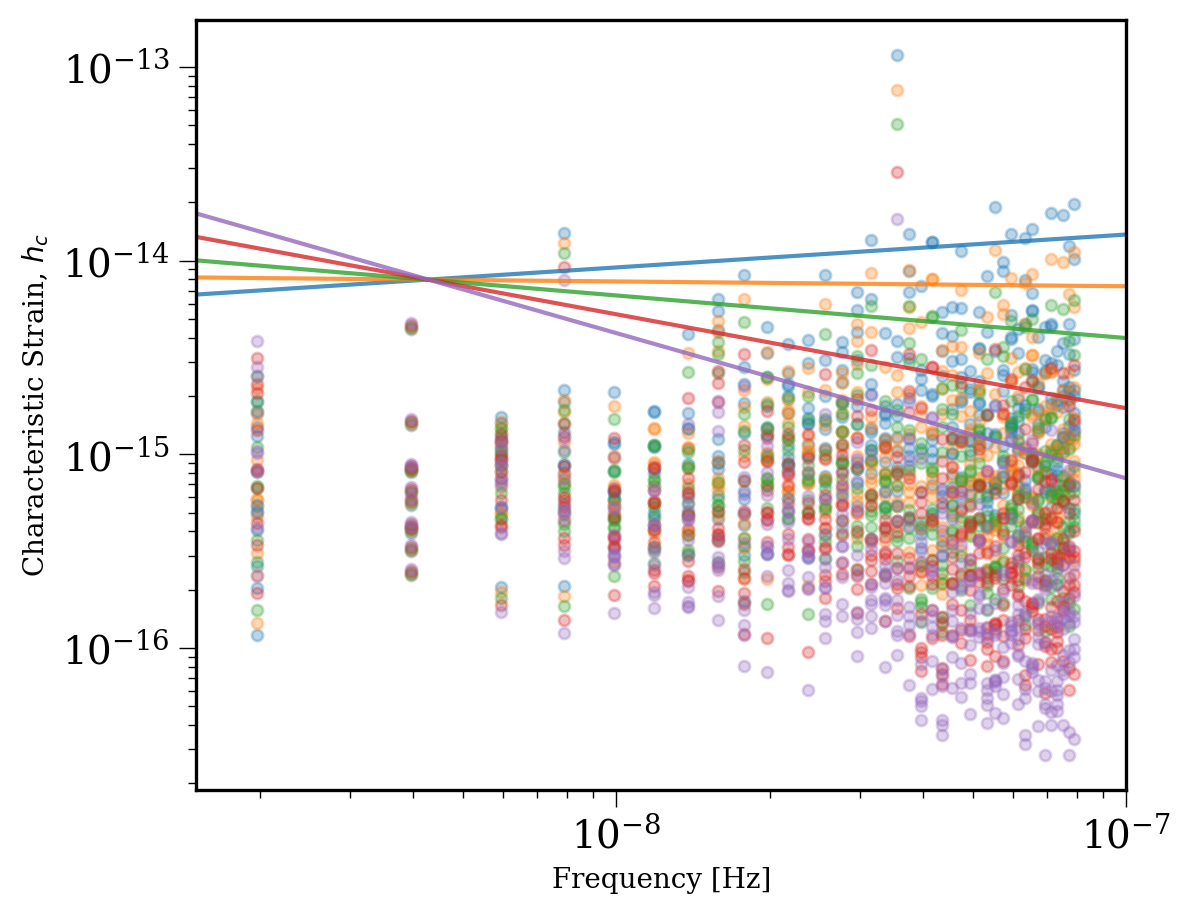

In [24]:
#compare NG15y like population to 3p+ like population
fig=plt.figure(figsize=(6,5))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
for i in range(len(A_gwbs)):
    plt.loglog(freqs, inj_gwb_hcs[i], color=f"C{i}", alpha=0.8, linewidth=1.5)
    for j in range(1000)[::100]:
        plt.scatter(fobs, varying_cis[i][:,j]*hc_ss[:,j,0], alpha=0.3, color=f'C{i}', zorder=0)#color=colors[rr])
plt.xlim(1.5e-9, 1e-7)
#plt.ylim(0.5e-16, 0.6e-13)
#plt.loglog(fobs, np.median(hc_bg, axis=1), color='k')
#plt.legend(fontsize=12,loc=3)
plt.show()

In [26]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
end_year=30
for i in range(len(alpha_gwbs)):
    hpsrs = sim_pta_w_inj_gwb(A_gwb=10**A_gwbs[i], alpha_gwb=alpha_gwbs[i])
    thirty_yr_spec = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
    )
    GWBSCs.append(hsen.GWBSensitivityCurve(thirty_yr_spec))
    SMs.append(hsky.SkySensitivity(spectra=thirty_yr_spec, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))

Creaing array of 157 psrs with injected A_gwb: -13.95 and alpha_gwb: 0.17 ...
PTA spectrum with 133 psrs created.
Creaing array of 157 psrs with injected A_gwb: -14.12 and alpha_gwb: -0.02 ...
PTA spectrum with 133 psrs created.
Creaing array of 157 psrs with injected A_gwb: -14.29 and alpha_gwb: -0.22 ...
PTA spectrum with 132 psrs created.
Creaing array of 157 psrs with injected A_gwb: -14.52 and alpha_gwb: -0.49 ...
PTA spectrum with 133 psrs created.
Creaing array of 157 psrs with injected A_gwb: -14.75 and alpha_gwb: -0.75 ...
PTA spectrum with 133 psrs created.


### do the det stats where we figure out which frequency bin the first detection will be in.

In [27]:
freq_bin_idxs = [np.argmin(abs(fobs[indx]-freqs)) for indx in range(len(fobs))]

In [28]:
strainns = np.array([[hutils.char_strain_to_strain_amp(varying_cis[i][:,j]*hc_ss[:,j,0], fobs, dfobs) for j in range(1000)] for i in range(len(A_gwbs))])
strainns.swapaxes(1,2)
strainns.shape

(5, 1000, 40)

In [29]:
# # convert our characteristic strain to strain amplitude
# out_of_order_array = np.array([np.array([hutils.char_strain_to_strain_amp(c_i[:,realization]*hc_ss[:,realization, loudest], fobs, dfobs) for loudest in range(len(hc_ss[0,0,:]))]) for realization in range(len(hc_ss[0,:,0]))])
# h_amp_ss = np.swapaxes(out_of_order_array, 0,1).T
# h_amp_ss.shape

In [30]:
snr_gridd = SMs[0].sky_ave_SNR_gridded(
        np.linspace(0, np.pi, 50),
        np.linspace(-np.pi/4, np.pi/4, 50),
        freq_bin_idxs
)

In [31]:
mdp_per_sm = []
for s, sky_map in enumerate(SMs):
    gridded = sky_map.sky_ave_SNR_gridded(
        np.linspace(0, np.pi, 50),
        np.linspace(-np.pi/4, np.pi/4, 50),
        freq_bin_idxs
    )
    max_dp = np.argmax([
        [1 - sky_map.false_dismissal_prob(
                         F_thresh=8.89,
                         ave='prob',
                         prob_kwargs={
                             'h0':strainns[s, it, fidxx],
                             'fidx': fidxx,
                             'int_method':'trapz',
                             'snr_grid': gridded}) 
       for it in range(0, 1000)
       ]
        for fidxx in range(len(freq_bin_idxs))
        ], axis = 0)
    mdp_per_sm.append(max_dp)

In [32]:
mdp_per_sm = np.array(mdp_per_sm)
mdp_per_sm.shape

(5, 1000)

In [33]:
# fbins = np.array([np.argmax(dp[bg], axis=0) for bg in range(len(A_gwbs))])

In [34]:
nhzs = (fobs*u.Hz).to('nHz')

In [34]:
#gamma_gwbs = [2.5, 2.8, 3.15, 3.44, 3.8, 4.15, 4.5]
#A_gwbs = [-13.9, -14.1, -14.2, -14.29, -14.4, -14.65, -14.72]
gamma_gwbs = [2.66, 3.05, 3.44, 3.97,4.5]
A_gwbs = [-13.95, -14.12, -14.29, -14.52, -14.75]
gamma_gwbs_l = [2.7, 3.1, 3.4, 4.0 ,4.5]
A_gwbs_l = [-14.0, -14.1, -14.3, -14.5, -14.8]
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
alpha_gwbs = (3. - np.array(gamma_gwbs)) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)
S_hs = []
inj_gwb_hcs = []
[S_hs.append(hsen.S_h(A=10**A_gwbs[i], alpha=alpha_gwbs[i], freqs=freqs)) for i in range(len(alpha_gwbs))]
[inj_gwb_hcs.append(np.sqrt(hsen.S_h(A=10**A_gwbs[idx], alpha=alpha_gwbs[idx], freqs=freqs)*freqs)) for idx, _ in enumerate(S_hs)]

[None, None, None, None, None]

In [35]:
f = ticker.ScalarFormatter(useMathText=True)
#f.set_powerlimits((-3,3))
legs = [
        mpl.lines.Line2D([0], [0], color='C4', linestyle='-', label=r"$\log_{10}\rm A_{\rm GWB}$: "+"${}$".format(A_gwbs_l[4])+r", $\gamma_{\rm GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[4]))),
        mpl.lines.Line2D([0], [0], color='C3', linestyle='-', label=r"$\log_{10}\rm A_{\rm GWB}$: "+"${}$".format(A_gwbs_l[3])+r", $\gamma_{\rm GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[3]))),
        mpl.lines.Line2D([0], [0], color='C2', linestyle='-', label=r"$\log_{10}\rm A_{\rm GWB}$: "+"${}$".format(A_gwbs_l[2])+r", $\gamma_{\rm GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[2]))),
        mpl.lines.Line2D([0], [0], color='C1', linestyle='-', label=r"$\log_{10}\rm A_{\rm GWB}$: "+"${}$".format(A_gwbs_l[1])+r", $\gamma_{\rm GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[1]))),
        mpl.lines.Line2D([0], [0], color='C0', linestyle='-', label=r"$\log_{10}\rm A_{\rm GWB}$: "+"${}$".format(A_gwbs_l[0])+r", $\gamma_{\rm GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[0]))),
        ]

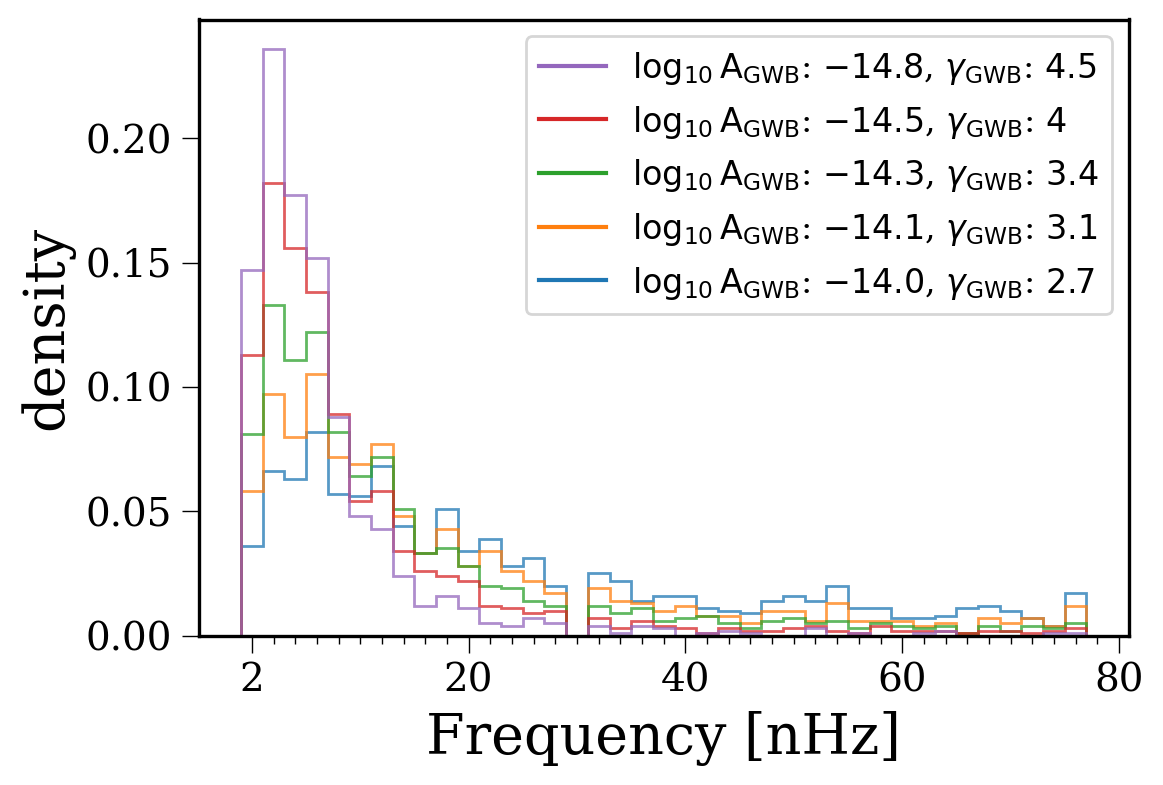

In [37]:
fig, ax1 = plt.subplots(figsize=(6,4))
for bg in range(len(A_gwbs)):
    plt.hist(mdp_per_sm[bg],bins=range(40), density=True, alpha=0.75, histtype='step')
plt.xticks(np.linspace(0.5,40.5, 41), minor=True, fontsize=14)
plt.xticks(np.linspace(0.5,40.5, 5), minor=False)
ax1.set_xticklabels([2, 20, 40, 60, 80])
plt.xlabel("Frequency [nHz]", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.legend(handles=legs, fontsize=12)
#plt.savefig(f'{fig_dir}/varied_gamma_fbin_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

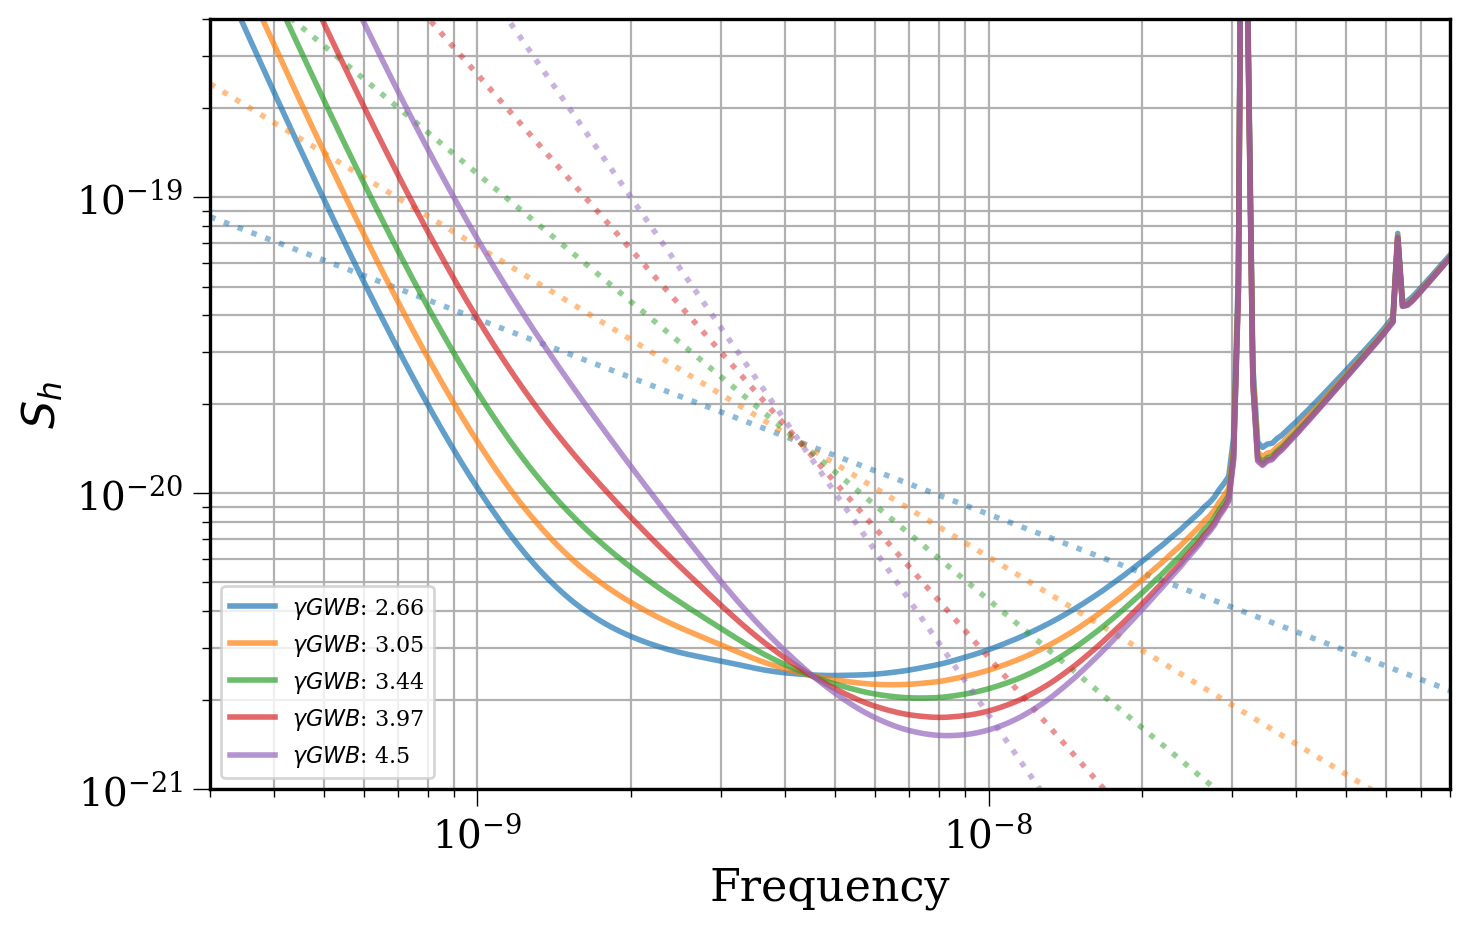

In [38]:
# Plot GWB SC
plt.figure(figsize=[8,5])
for i, sc in enumerate(GWBSCs):
    plt.loglog(sc.freqs, sc.S_eff,label=f"$\gamma GWB$: {gamma_gwbs[i]}", color = f"C{i}", linewidth= 2, alpha=0.7)
    #, $log10(Agwb)$: {A_gwbs[i]}
    plt.loglog(sc.freqs, S_hs[i], color = f'C{i}', linewidth=2, linestyle = ":", alpha=0.5)
plt.legend(loc='lower left', fontsize=8)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('$S_h$', fontsize=16)
plt.xlim((3e-10,8e-8))
plt.ylim((1e-21,4e-19))
#plt.title('GPTA GWB Sensitvity', fontsize = 24)
plt.grid(which='both')
#plt.savefig(f'{fig_dir}/varied_gamma_gwbs.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [39]:
# different_bgs = np.array([i for i in range(0,len(GWBSNRs))])
# gamma_gwbss = [gamma_gwbs[i] for i in [0, 3, 6]]
# plt.plot(gamma_gwbss, GWBSNRs, marker='o')
# plt.title(f"S/N @{end_year}yrs for different injected GWBs")
# plt.xlabel("injected $\gamma_{GWB}$ values", fontsize=14)
# plt.ylabel("GWB S/N", fontsize=16)
# plt.xticks(gamma_gwbss,fontsize=12)
# #plt.xlim((0,5))
# plt.yticks(fontsize=12)
# plt.show()

### See how our alt. campaigns differ for different $\gamma_{GWB}$ values

In [25]:
# sources
#mass in Msun, D_L in Mpc, f(_GW?) in Hz
s1 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=7e-10).to('')
s2 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=4e-9).to('')
s3 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=1.15e-8).to('')
s4 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=2.8e-8).to('')
source_h0s = [s1.value, s2.value, s3.value, s4.value]
#h0_freqs = [7e-10, 4e-9, 1.15e-8, 2.8e-8] 
# swapping to the below since they fit our curve better?
h0_freqs = [2e-9, 5e-9, 2e-8, 4e-8]
source_freqs = [np.argmin(abs(freqs-h0_freqs[i])) for i in range(len(h0_freqs))]
source_h0s

[2.7443824468119924e-15,
 8.77174370311675e-15,
 1.7735543416856256e-14,
 3.2098491819673166e-14]

In [33]:
f = ticker.ScalarFormatter(useMathText=True)
#f.set_powerlimits((-3,3))
legs = [
        mpl.lines.Line2D([0], [0], color='C4', linestyle='-', label="$\log_{10}A_{GWB}$: "+"${}$".format(A_gwbs_l[4])+", $\gamma_{GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[4]))),
        mpl.lines.Line2D([0], [0], color='C3', linestyle='-', label="$\log_{10}A_{GWB}$: "+"${}$".format(A_gwbs_l[3])+", $\gamma_{GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[3]))),
        mpl.lines.Line2D([0], [0], color='C2', linestyle='-', label="$\log_{10}A_{GWB}$: "+"${}$".format(A_gwbs_l[2])+", $\gamma_{GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[2]))),
        mpl.lines.Line2D([0], [0], color='C1', linestyle='-', label="$\log_{10}A_{GWB}$: "+"${}$".format(A_gwbs_l[1])+", $\gamma_{GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[1]))),
        mpl.lines.Line2D([0], [0], color='C0', linestyle='-', label="$\log_{10}A_{GWB}$: "+"${}$".format(A_gwbs_l[0])+", $\gamma_{GWB}$: "+"${}$".format(f.format_data(gamma_gwbs_l[0]))),
        ]

NameError: name 'A_gwbs_l' is not defined

# Source Properties
|Source Name| Mass [ Msun ] | $L_\text{D}$ [Log10 Mpc] | $f_{\text{GW}}$ [Log10 Hz] | $h_0$ [ ] |
|:---:|:---:|:---:|:-------:|:----:| 
|S1 | $10^9$ | $3.2$ | -10.8 | 2.7e-15 |
|S2 | $10^9$ | $3.2$  | -9.4 | 8.7e-15 |
|S3 | $10^9$ | $3.2$ | -8.15 | 1.77e-15 |
|S4 | $10^9$ | $3.2$ | -8.28 | 3.2e-14 |

referencing [Liu et al.](https://iopscience-iop-org.oregonstate.idm.oclc.org/article/10.3847/1538-4357/acb492/pdf)

In [42]:
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


PTA spectrum with 133 psrs created.


In [43]:
start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [44]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.01
cadence_factor = 4
thin_cadence_factor = 1/2
pulsars_dropped_per_year = 6
iterations = 10

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [45]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered), np.intersect1d(idx_best_to_worst_filtered[:iterations], idx_sorted_filtered[iterations*pulsars_dropped_per_year:])

(119, array([  3,  32,  38,  53,  77,  79,  82,  92, 102, 113]))

In [55]:
GWBSCs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
GWBSNRs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
SNRs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
SMs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
for a_idx, alpha_value in enumerate(alpha_gwbs):
    hpsrs = sim_pta_w_inj_gwb(A_gwb=10**A_gwbs[a_idx], alpha_gwb=alpha_gwbs[a_idx])
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs[str(alpha_value)].append(hsen.GWBSensitivityCurve(spectra))
    SMs[str(alpha_value)].append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs[str(alpha_value)].append(GWBSCs[str(alpha_value)][-1].SNR(S_h))
    SNRs[str(alpha_value)].append([SMs[str(alpha_value)][-1].SNR(h_0) for h_0 in source_h0s])
    for i, psr_hcad in enumerate(idx_best_to_worst_filtered[:iterations]): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
        for idx in range(pulsars_dropped_per_year):
            print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[idx_sorted_filtered[i*pulsars_dropped_per_year+idx]].name)
            hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].change_cadence(
                    start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                    cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                    A_gwb=10**A_gwbs[a_idx], alpha_gwb=alpha_gwbs[a_idx], freqs=freqs)
            # altar cadences with .change_cadence()
        print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
        #print("toas before: ", len(hpsrs[psr_hcad].toas))
        hpsrs[psr_hcad].change_cadence(
            start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
            cadence=None, cadence_factor=cadence_factor, uneven=True,
            A_gwb=10**A_gwbs[a_idx], alpha_gwb=alpha_gwbs[a_idx], freqs=freqs,
            )
        #print("toas after: ", len(hpsrs[psr_hcad].toas))
        # create some psr spectra
        spectra = get_sliced_spectra(
                    psrs=hpsrs,
                    start_mjd=-1000,
                    end_mjd=end_year*365.25
                )
        GWBSCs[str(alpha_value)].append(hsen.GWBSensitivityCurve(spectra))
        SMs[str(alpha_value)].append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
        GWBSNRs[str(alpha_value)].append(GWBSCs[str(alpha_value)][-1].SNR(S_h))
        SNRs[str(alpha_value)].append([SMs[str(alpha_value)][-1].SNR(h_0) for h_0 in source_h0s])


Creaing array of 157 psrs with injected A_gwb: -13.95 and alpha_gwb: 0.17 ...
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 690
1:4) reducing pulsar  J0326+0145
old: 792, new: 692
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 562
quadrupuling pulsar  J1907-0212
old: 694, new: 1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1135+0251
old: 684, new: 584
2:2) reducing pulsar  J2100-0048
old: 557, new: 457
2:3) reducing pulsar  J2052+0211
old: 550, new: 449
2:4) reducing pulsar  J1514-0303
old: 646, new: 546
2:5) reducing pulsar  J0122-0052
old: 566, new: 466
2:6) reducing pulsar  J2028-0020
old: 789, new: 688
quadrupuling pulsar  J1900-0226
old: 562, new: 1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J1726+0347
old: 658, new: 558
3:2) reducing pulsar  J2249-0019
o

KeyboardInterrupt: 

## try again here

In [26]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.1
cadence_factor = 4
thin_cadence_factor = 1/2
pulsars_dropped_per_year = (cadence_factor-1)/thin_cadence_factor
iterations = 10
pulsars_dropped_per_year

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


6.0

In [27]:
pulsars_dropped_per_year = int(pulsars_dropped_per_year)

In [28]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)
hpsrs[idx_best_to_worst_filtered[0]].toaerrs[0], hpsrs[idx_best_to_worst_filtered[-1]].toaerrs[0] 
##### idx_best_to_worst_filtered from the GWB droupout
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

psrs_high_cad = idx_best_to_worst_filtered[:iterations]
psrs_removed = idx_sorted_filtered
psrs_high_cad, psrs_removed
#check that you are not removing and increasing cadence (intersection should be zero)
np.intersect1d(psrs_high_cad, psrs_removed[:iterations*pulsars_dropped_per_year])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


array([], dtype=int64)

In [29]:
GWBSCs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
GWBSNRs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
SNRs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
SMs = {str(alpha_value): [] for alpha_value in alpha_gwbs}
for a_idx, alpha_value in enumerate(alpha_gwbs):
    hpsrs = sim_pta_w_inj_gwb(A_gwb=10**A_gwbs[a_idx], alpha_gwb=alpha_gwbs[a_idx])
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs[str(alpha_value)].append(hsen.GWBSensitivityCurve(spectra))
    SMs[str(alpha_value)].append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs[str(alpha_value)].append(GWBSCs[str(alpha_value)][-1].SNR(S_h))
    SNRs[str(alpha_value)].append([SMs[str(alpha_value)][-1].SNR(h_0) for h_0 in source_h0s])
    for i, psr_hcad in enumerate(idx_best_to_worst_filtered[:iterations]): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
        for idx in range(pulsars_dropped_per_year):
            print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[idx_sorted_filtered[i*pulsars_dropped_per_year+idx]].name)
            hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].change_cadence(
                    start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                    cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                    A_gwb=10**A_gwbs[a_idx], alpha_gwb=alpha_gwbs[a_idx], freqs=freqs)
            # altar cadences with .change_cadence()
        print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
        #print("toas before: ", len(hpsrs[psr_hcad].toas))
        hpsrs[psr_hcad].change_cadence(
            start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
            cadence=None, cadence_factor=cadence_factor, uneven=True,
            A_gwb=10**A_gwbs[a_idx], alpha_gwb=alpha_gwbs[a_idx], freqs=freqs,
            )
        #print("toas after: ", len(hpsrs[psr_hcad].toas))
        # create some psr spectra
        spectra = get_sliced_spectra(
                    psrs=hpsrs,
                    start_mjd=-1000,
                    end_mjd=end_year*365.25
                )
        GWBSCs[str(alpha_value)].append(hsen.GWBSensitivityCurve(spectra))
        SMs[str(alpha_value)].append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
        GWBSNRs[str(alpha_value)].append(GWBSCs[str(alpha_value)][-1].SNR(S_h))
        SNRs[str(alpha_value)].append([SMs[str(alpha_value)][-1].SNR(h_0) for h_0 in source_h0s])

Creaing array of 157 psrs with injected A_gwb: -13.95 and alpha_gwb: 0.17 ...
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 450
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 691
1:4) reducing pulsar  J0326+0145
old: 792, new: 691
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 562
quadrupuling pulsar  J1907-0212
old: 694, new: 1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1135+0251
old: 684, new: 584
2:2) reducing pulsar  J2100-0048
old: 557, new: 457
2:3) reducing pulsar  J2052+0211
old: 550, new: 449
2:4) reducing pulsar  J1514-0303
old: 646, new: 546
2:5) reducing pulsar  J0122-0052
old: 566, new: 466
2:6) reducing pulsar  J2028-0020
old: 789, new: 688
quadrupuling pulsar  J1900-0226
old: 562, new: 1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J1726+0347
old: 658, new: 558
3:2) reducing pulsar  J2249-0019
o

## to here

In [30]:
GWBSNRs[str(alpha_gwbs[0])][0]

30.833795468825365

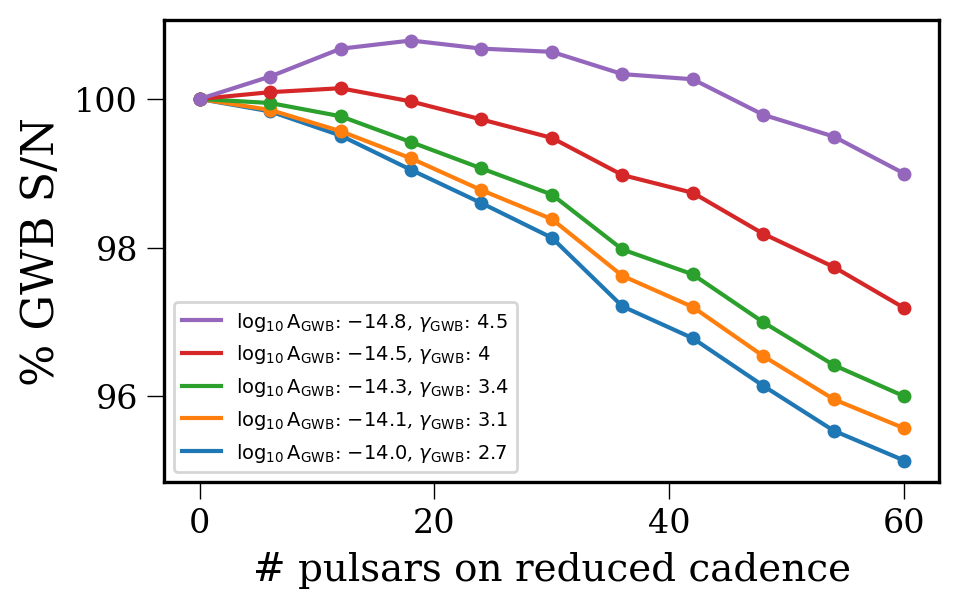

In [37]:
dropped = 6*np.array([i for i in range(0,len(GWBSNRs[str(alpha_gwbs[0])]))])
fig = plt.figure(figsize=(5,3))
for idx, alph in enumerate(GWBSNRs):
    plt.plot(dropped, 100.*np.array(GWBSNRs[str(alph)]/GWBSNRs[str(alph)][0]), marker='o', label=f"$\gamma$gwb: {gamma_gwbs[idx]}")
plt.xlabel("# pulsars on reduced cadence", fontsize=14)
plt.ylabel("% GWB S/N", fontsize=16)
plt.legend(handles=legs)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig(f'{fig_dir}/varied_gamma_gwb_snr.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

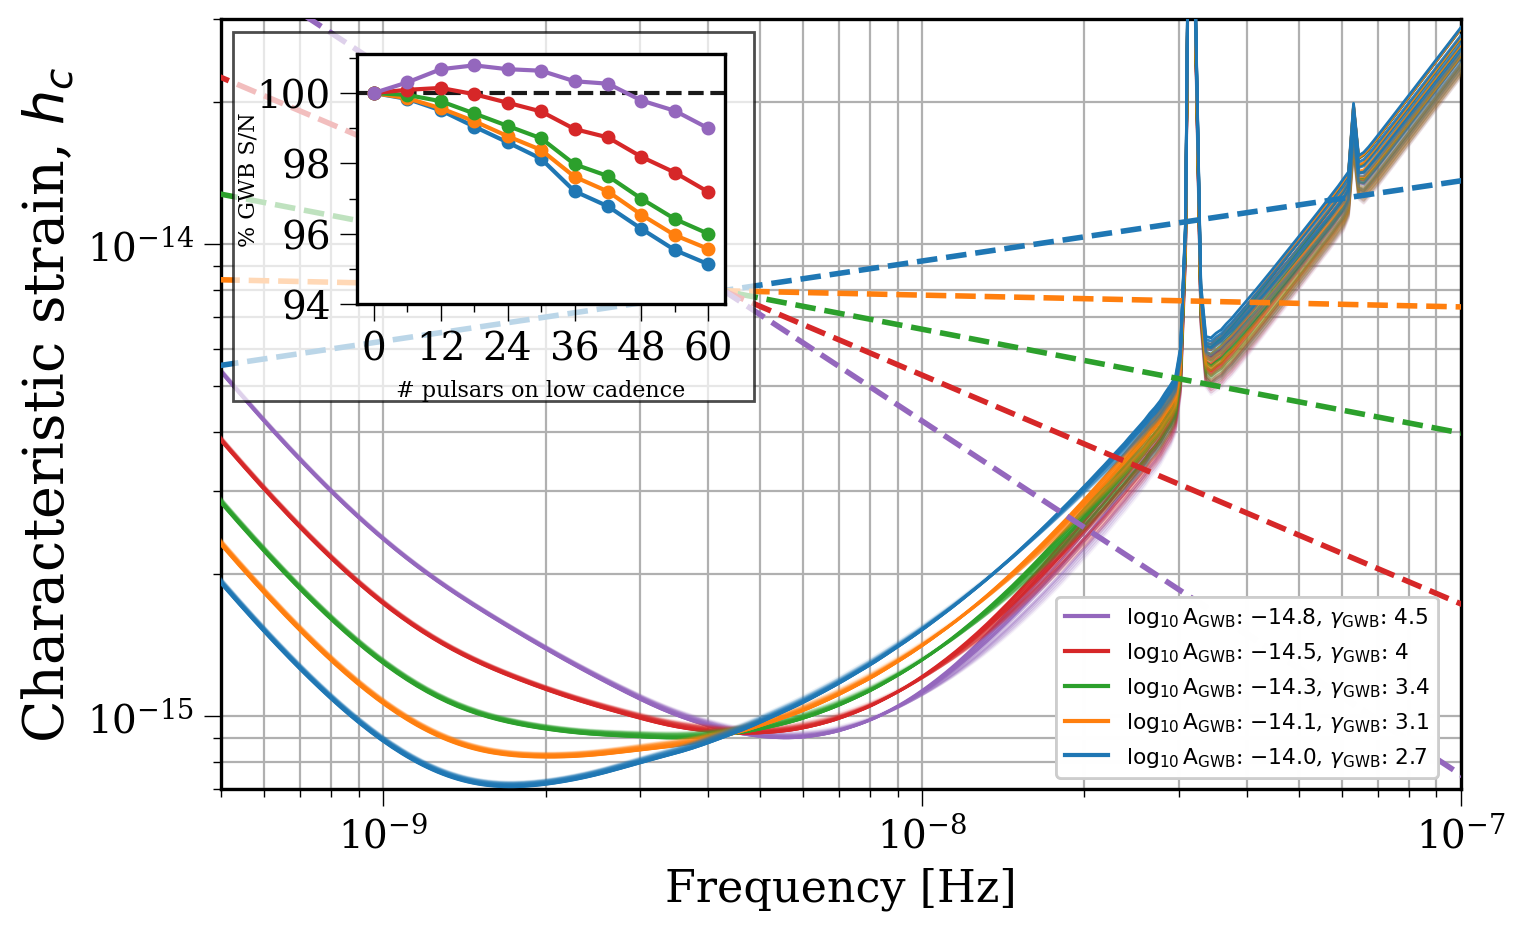

In [ ]:
# Plot skymap SC
# color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs[str(alpha_gwbs[0])])))
linewidth=1
dropped = 6*np.array([i for i in range(0,len(GWBSNRs[str(alpha_gwbs[0])]))])
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1,zorder=0)
for a_idx, alph in enumerate(SMs):
    for camp_idx in np.flip(range(len(SMs[alph]))):
        plt.loglog(freqs, np.mean(SMs[alph][camp_idx].h_c, axis=1), 
                   color = f"C{a_idx}", linewidth=linewidth, alpha=(1-camp_idx/len(SMs[alph])),
                   zorder = 6-a_idx)
for i, inj in np.flip(enumerate(inj_gwb_hcs)):
     plt.plot(freqs, inj, linestyle='--', color=f'C{i}', linewidth=2, zorder=7)
leg1 = plt.legend(handles=legs, loc='lower right',
                  bbox_to_anchor=(.99, 0.001),framealpha=0.95,
                  fontsize=7.8)
leg1.set_zorder(20)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
plt.xlim((5e-10, 1e-7))
#plt.ylim((1e-16, 1e-13))
plt.ylim((7e-16, 3e-14))
# make the background for the inset
# leg2 = plt.legend([],bbox_to_anchor=(.30, 0.99, 0.5, 0.23), loc='upper left', facecolor='white', fancybox=True,)#borderpad=1
#loc_box = [.30, 0.2, 0.5, 0.23]
loc_box = [0.11, 0.604, 0.32, 0.38]
buffer=0.1
ax1.add_patch(plt.Rectangle((
    loc_box[0]-buffer, loc_box[1]-buffer,), 
    loc_box[2]+buffer, loc_box[3]+buffer, 
    linestyle="-", edgecolor="k", facecolor="w", 
    linewidth=1, alpha=0.7,zorder=21, #zorder=5, 
    transform=ax1.transAxes))
#ax1.set_zorder(20)
plt.grid(which='both', zorder=0)
plt.gca().add_artist(leg1)
# ax1.add_patch(plt.Rectangle((
#     loc_box[0]-buffer, loc_box[1]-buffer, 0.2, 0.2), 
#     loc_box[2]+buffer, loc_box[3]+buffer,
#     linestyle="-", edgecolor="k", facecolor="k", 
#     linewidth=2, alpha=0.75,zorder=100))
# ax1.add_patch(plt.Rectangle((),
#     linestyle="-", edgecolor="k", facecolor="k", 
#     linewidth=2, alpha=0.75,zorder=100))
#### make the inset plot
left, bottom, width, height = [0.21, 0.595, 0.23, 0.25]
#left, bottom, width, height = [0.63, 0.1, 0.25, 0.25]
ax3 = fig.add_axes([left, bottom, width, height], zorder=22)
ax3.axhline(100, color='black', alpha=0.9, linestyle='--')
for idx, alph in enumerate(GWBSNRs):
    ax3.plot(dropped, 100.*np.array(GWBSNRs[str(alph)]/GWBSNRs[str(alph)][0]), marker='o',)
ax3.set_xlabel('# pulsars on low cadence', fontsize=8)
ax3.set_ylabel("% GWB S/N", fontsize=8, labelpad = -1)
ax3.set_ylim((94,101.1))
ax3.set_yticks([94,96,98,100,])
ax3.set_yticks([95,96,97,98,99,100,101],minor=True)
ax3.set_xticks([0,12, 24, 36,48,60])
ax3.set_xticks([0,6, 12, 18, 24, 30, 36,48,54, 60],minor=True)
#ax3.legend(fontsize=6)

# plt.legend(handles=legs,
#            loc='upper left', fontsize=8,
#            )
#plt.savefig(f'{fig_dir}/varied_gamma_SCs.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [78]:
(1/(1e-9*u.Hz)).to('yr')

<Quantity 31.68808781 yr>

In [ ]:
# Plot skymap SC
# # color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs[str(alpha_gwbs[0])])))
# plt.figure(figsize=[8,5])
# for a_idx, alph in enumerate(SMs):
#     linewidth=1
#     for camp_idx in range(len(SMs[alph])):
#         if camp_idx == 0:
#             plt.loglog(freqs, 2*np.mean(SMs[alph][camp_idx].h_c, axis=1),label=f"$\gamma$gwb: {gamma_gwbs[a_idx]}", color = f"C{a_idx}", linewidth=linewidth, alpha=1)
#         else:
#             plt.loglog(freqs, 2*np.mean(SMs[alph][camp_idx].h_c, axis=1), color = f"C{a_idx}", linewidth=linewidth, alpha=(1-camp_idx/len(SMs[alph])))

# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# # for i in range(len(h0_freqs)):
# #     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)

# for i, inj in np.flip(enumerate(inj_gwb_hcs)):
#      plt.plot(freqs, inj, linestyle='--', color=f'C{i}', linewidth=2)
# plt.legend(handles=legs,
#            loc='upper left', fontsize=8,
#            )
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
# plt.grid(which='both')
# plt.xlim((1e-9, 1e-7))
# plt.ylim((2e-15, 1e-13))
# plt.savefig(f'{fig_dir}/varied_gamma_SCs.pdf', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()

In [ ]:
SMs

In [ ]:
SNRs = {}
for a_idx, alph in enumerate(alpha_gwbs):
    SNRs[str(alph)] = []
    for i in range(12):
        SNRs[str(alph)].append([0.5*np.mean(SMs[str(alph)][i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])

In [ ]:
SNRs

In [ ]:
dropped = 3*np.array([i for i in range(12)])
for a_idx, alph in enumerate(alpha_gwbs):
    #for s_idx in range(len(source_h0s)):
    plt.plot(dropped, SNRs[str(alph)][0], marker='o', color=f"C{a_idx}", label=f"source freq: {freqs[source_freqs[s_idx]]:.1e} Hz")
plt.title("Source S/N swapping 3psr for a x4 high cadence, yr 20->30")
plt.xlabel("Pulsars no longer observed", fontsize=14)
plt.ylabel("Change in source SNR", fontsize=16)
plt.legend(loc=(0.01,0.45))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()